In [1]:
BGC_type = 'nitrile_hydratase_beta'

In [2]:
import os
from os import listdir, mkdir
from os.path import isfile, join
import pandas as pd
from pathlib import Path
#import plotnine #currently installed in home. Should better be under project, but couldn't figure it out
from plotnine import ggplot, aes, geom_point, geom_text, scale_x_continuous, scale_y_continuous, geom_smooth

So far this assumes that antismash results for positive and negative base genomes exist already, otherwise include a step here that sends off a slurm job for antismash.

Requires:
- coverage tables (add script that puts them together)
- metabgc quantify results (unique-biosynthetic-reads-abundance-table-wide.txt)

In [3]:
# Helper function for making directories only if they don't exist yet
def makedir(dirpath):
    if os.path.isdir(dirpath):
        print(dirpath,'exists already')
    else:
        print('Making', dirpath)    
        os.mkdir(dirpath)

        
# Defining paths for required directory structure for input and output files relative to parent directory
parent_dir= !echo $(pwd)
BGC_path=os.path.join(parent_dir[0], BGC_type)
coverage_table_path=os.path.join(BGC_path, 'validation_coverage_tables')
metabgc_quantify_path=os.path.join(BGC_path, 'mbgc_quantify_results')
results_path=os.path.join(BGC_path, 'validation_results')


# Calling function to make directories if they don't exist yet
makedir(coverage_table_path)
makedir(metabgc_quantify_path)
makedir(results_path)

/media/manu/RiPP_Prioritiser/nitrile_hydratase_beta/validation_coverage_tables exists already
/media/manu/RiPP_Prioritiser/nitrile_hydratase_beta/mbgc_quantify_results exists already
/media/manu/RiPP_Prioritiser/nitrile_hydratase_beta/validation_results exists already


In [4]:
# Parses mbgc quantify output tables and generates a dataframe that links each input genome 
#to the amount of unique biosynthetic reads found.

os.chdir(metabgc_quantify_path)

#list filenames in mbgc directory
filenames = [f for f in listdir(metabgc_quantify_path) if isfile(join(metabgc_quantify_path, f))]

# As all files the quantify result files come out of mbgc with an identical filename, it is required that the
# filenames are changed in such a way that they are unique before copying all these files into the metabgc_quantify_path.
# Simply append the name of the directory they are contained in to the filename, e.g.:
# unique-biosynthetic-reads-abundance-table-wide_7375_S148.txt
# This in turn has to match the name of the coverage table file that the synthetic metagenome is based on.
# See the matching sample in the cell below.
mbgc_dict = {}
for file in filenames:
#    key = '_'.join(file.split('_')[-2:]).strip('.txt')
#    key = '_'.join(file.split('_')[3:5])
    key = file.strip('_unique-biosynthetic-reads-abundance-table-wide.txt')
    with open(file) as f:
        read_count=0
        for i, l in enumerate(f):
            read_count +=1
            pass
    mbgc_dict[key] = read_count-1

count_df = pd.DataFrame.from_dict(mbgc_dict,orient='index').reset_index()
count_df.columns = ['metagenome', 'mbgc_count']
print(count_df)

#output
#    metagenome  mbgc_count
#0  7375_S39313         234
#1   7375_S5507         185
#2      7375_S6          67
#3     7375_S72         217
#4      7375_S8          41

                    metagenome  mbgc_count
0    3_7_0.3_nifhbSynSponge_11          22
1    5_5_0.9_nifhbSynSponge_16          14
2   10_0_0.3_nifhbSynSponge_30          91
3   10_0_0.3_nifhbSynSponge_31         170
4   10_0_0.3_nifhbSynSponge_32          98
5   10_0_0.9_nifhbSynSponge_31          57
6     1_9_0.3_nifhbSynSponge_3           1
7     2_8_0.3_nifhbSynSponge_6           5
8     2_8_0.3_nifhbSynSponge_8           2
9    3_7_0.3_nifhbSynSponge_10           6
10    3_7_0.3_nifhbSynSponge_9          36
11   3_7_0.9_nifhbSynSponge_11          13
12   4_6_0.3_nifhbSynSponge_12          43
13   4_6_0.3_nifhbSynSponge_13          19
14   5_5_0.3_nifhbSynSponge_15          20
15   5_5_0.3_nifhbSynSponge_16          12
16   5_5_0.3_nifhbSynSponge_17         175
17   5_5_0.9_nifhbSynSponge_15          27
18   6_4_0.3_nifhbSynSponge_18           6
19   6_4_0.3_nifhbSynSponge_19         109
20   7_3_0.3_nifhbSynSponge_21          33
21   7_3_0.3_nifhbSynSponge_23         121
22   8_2_0.

In [13]:
os.chdir(coverage_table_path)

cov_table_files = [f for f in listdir(coverage_table_path) if isfile(join(coverage_table_path, f))]
#for count, value in enumerate(cov_table_files):
#    print(count,value)

# This requires that the coverage table filename follows a certain naming convention so that the metagenome name
# Can be parsed out of it and a dataframe be built by mapping based on this name
# naming: pos-genomes_neg-genomes_metagenome-name_metagenome-number.csv, e.g. 0_15_7375_S148.csv
pos_genomes_dict = {}
for file in cov_table_files:
    value = file.split('_')[0]
    pos_genomes_dict[file] = value

# add pos_genomes_count_column to count_df
count_df['pos_genomes_count'] = count_df['metagenome'].map(pos_genomes_dict)

# At the moment, this parses more information out of the files than necessary for the following plot
# This is a remnant of previouly plotting different metrics against each other before settling on this one
# However, they might still be of interest.
genome_names_dict = {}
coverage_dict = {}
for file in cov_table_files:
    with open(file) as f:
        line = f.readlines()
        pos_lines = line[-10:] #Assumes 10 pos genomes
        genome_names_list = []
        coverage_sum = 0
        for i in pos_lines:
            if float(i.split(',')[-1:][0].strip('\n')) != 0:
                genome_names_list.append(i.split(',')[2].strip('.fna'))
                coverage_sum += float(i.split(',')[-1:][0].strip('\n'))

            genome_names_dict[file] = genome_names_list
            coverage_dict[file] = coverage_sum

#genome names disregarded, for now assuming that each genome has only 1 cluster of interest
count_df['coverage_sum'] = count_df['metagenome'].map(coverage_dict)
count_df['pos_genome_names'] = count_df['metagenome'].map(genome_names_dict)

#count_df.to_csv(results_path+'/count_df.tsv', sep='\t',index=False)

#print(count_df)


                    metagenome  mbgc_count pos_genomes_count  coverage_sum  \
0    3_7_0.3_nifhbSynSponge_11          22                 3     12.617997   
1    5_5_0.9_nifhbSynSponge_16          14                 5     27.532177   
2   10_0_0.3_nifhbSynSponge_30          91                10     79.658167   
3   10_0_0.3_nifhbSynSponge_31         170                10    313.775094   
4   10_0_0.3_nifhbSynSponge_32          98                10     60.138172   
5   10_0_0.9_nifhbSynSponge_31          57                10     43.053412   
6     1_9_0.3_nifhbSynSponge_3           1                 1      0.730440   
7     2_8_0.3_nifhbSynSponge_6           5                 2      5.341617   
8     2_8_0.3_nifhbSynSponge_8           2                 2      4.065676   
9    3_7_0.3_nifhbSynSponge_10           6                 3     59.462782   
10    3_7_0.3_nifhbSynSponge_9          36                 3     20.540402   
11   3_7_0.9_nifhbSynSponge_11          13                 3    

In [48]:
#This produces a replica of Fig. S9 of the 2019 Sugimoto paper and saves it

p=(
     ggplot(count_df)
     + aes(x=count_df.loc[:,'coverage_sum'], y=count_df.loc[:,'mbgc_count'], label = count_df.loc[:,'pos_genomes_count'])
     + geom_point()
     + geom_text(nudge_y = 10, size=8)
     + scale_x_continuous()
     + scale_y_continuous()
     + geom_smooth(method='lm', inherit_aes=True, alpha=0.25, size=0.25, color='red', se=True)
)

p.save(results_path+'/comparison.png', height=5, width=7, units = 'in', dpi=300)

/home/manu/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/manu/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /media/manu/RiPP_Prioritiser/nitrile_hydratase_beta/validation_results/comparison.png


In [11]:
#Calculate correlation
#https://www.kite.com/python/answers/how-to-find-the-correlation-between-two-pandas-dataframe-columns-in-python
#upgrade to this later to show on plot: https://stackoverflow.com/questions/61131266/add-regression-line-equation-and-r-square-to-a-plotnine

col_1 = count_df['coverage_sum']
col_2 = count_df['mbgc_count']
correlation = col_1.corr(col_2)
Rsq = correlation*correlation
print(correlation)
print(Rsq)


0.8572168053473801
0.7348206513699681


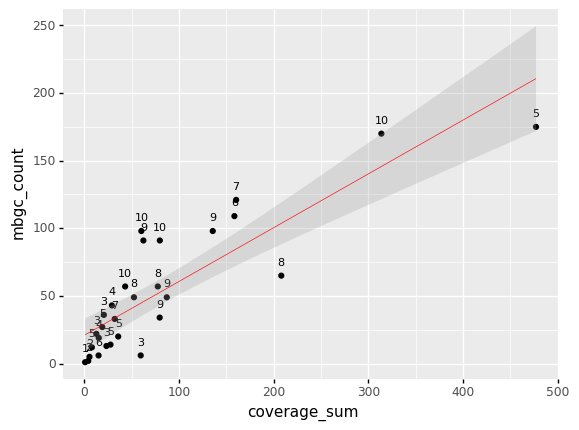

<ggplot: (8789582093288)>

In [9]:
#This shows the same plot

(
     ggplot(count_df)
     + aes(x=count_df.loc[:,'coverage_sum'], y=count_df.loc[:,'mbgc_count'], label = count_df.loc[:,'pos_genomes_count'])
     + geom_point()
     + geom_text(nudge_y = 10, size=8)
     + scale_x_continuous()
     + scale_y_continuous()
     + geom_smooth(method='lm', inherit_aes=True, alpha=0.25, size=0.25, color='red', se=True)
)